In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def read_json(filename):
    with open(filename, 'r') as f:
        datastore = json.load(f)
        return datastore

In [3]:
folder = 'data/'
filename = {'train_orig': 'ds_train_orig.csv',
            'train_imp': 'ds_train_imp.csv',
            'test': 'ds_test.csv'}
df = {}
for set_type in filename:
    df[set_type] = pd.read_csv(folder + filename[set_type], index_col=0)

/home/zhangvwk/.local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
### UNDERSAMPLING THE MINORITY CLASS ###
def undersample(df):
    no_onsight = len(df[df['is_onsight'] == 1])
    non_onsight_indices = df[df['is_onsight'] == 0].index
    random_indices = np.random.choice(non_onsight_indices, no_onsight, replace=False)
    onsight_indices = df[df['is_onsight'] == 1].index
    under_sample_indices = np.concatenate([onsight_indices,random_indices])
    under_sample = df.loc[under_sample_indices]
    return under_sample

In [13]:
bal_orig = undersample(df['train_orig'])
bal_imp = undersample(df['train_imp'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126050 entries, 6 to 639120
Data columns (total 10 columns):
user_id          1126050 non-null int64
country          1126050 non-null int64
is_female        1126050 non-null int64
height           1126050 non-null float64
started          1126050 non-null float64
birth            1126050 non-null float64
grade_id         1126050 non-null int64
is_onsight       1126050 non-null int64
is_bouldering    1126050 non-null int64
year             1126050 non-null int64
dtypes: float64(3), int64(7)
memory usage: 94.5 MB


In [14]:
under_sample.to_csv('balanced_orig.csv')

In [4]:
# Proportion of is_bouldering 
for set_type in df:
    print("*********************************")
    print("************ Set: {} ".format(set_type))
    print("*********************************")
    print(df[set_type]['is_bouldering'].value_counts(normalize=True) * 100)
    print("--------------------------------")
    # Proportion of is_onsight 
    print(df[set_type]['is_onsight'].value_counts(normalize=True) * 100)
    print("--------------------------------")
    # Proportion of is_female 
    print(df[set_type]['is_female'].value_counts(normalize=True) * 100)

*********************************
************ Set: train_orig 
*********************************
0    70.590577
1    29.409423
Name: is_bouldering, dtype: float64
--------------------------------
0    67.977411
1    32.022589
Name: is_onsight, dtype: float64
--------------------------------
0    92.08207
1     7.91793
Name: is_female, dtype: float64
*********************************
************ Set: train_imp 
*********************************
0    71.016153
1    28.983847
Name: is_bouldering, dtype: float64
--------------------------------
0    68.194371
1    31.805629
Name: is_onsight, dtype: float64
--------------------------------
0    89.506472
1    10.493528
Name: is_female, dtype: float64
*********************************
************ Set: test 
*********************************
0    69.155399
1    30.844601
Name: is_bouldering, dtype: float64
--------------------------------
0    69.862064
1    30.137936
Name: is_onsight, dtype: float64
--------------------------------
0    9

Skewed towards lead climbing, non onsight ascents, and male.

In [65]:
for set_type in df:
    print("*********************************")
    print("************ Set: {} ".format(set_type))
    print("*********************************")

    # Proportion of countries
    country_proportion = df[set_type]['country'].value_counts(normalize=True) * 100
    # country_proportion.plot.bar()
    # plt.show()
    # country_proportion.cols
    country_proportion = pd.DataFrame({'country_id':country_proportion.index, '%':country_proportion.values})
    country2idx = read_json('data/country2idx.json')
    idx2country = {v: k for k, v in country2idx.items()}
    country_proportion['country'] = country_proportion['country_id'].map(idx2country)
    n = 20
    print("Top {} represented countries:".format(n))
    print(country_proportion.nlargest(n, '%'))
    print("There are in total {} countries represented in this dataset.".format(len(country2idx)))
    print("The top 10 represented countries take up {} % of the entire dataset.".format(country_proportion.nlargest(10, '%')['%'].sum()))

*********************************
************ Set: train_orig 
*********************************
Top 20 represented countries:
            %  country_id country
0   13.105644          21     ESP
1   12.667244           1     USA
2    9.520069          17     POL
3    6.664327           8     DEU
4    6.240601          14     ITA
5    5.721722           0     SWE
6    5.327913          15     FRA
7    3.901350          26     BRA
8    3.570218           7     AUT
9    3.267524           3     NOR
10   2.879744          24     CHE
11   2.679085           9     CAN
12   2.356769          13     GBR
13   2.193478           4     NLD
14   1.748310          12     SVN
15   1.733295          20     ZAF
16   1.642237           2     AUS
17   1.513071           5     BEL
18   1.386750           6     PRT
19   1.247688          45     RUS
There are in total 209 countries represented in this dataset.
The top 10 represented countries take up 69.98661139839793 % of the entire dataset.
************

No country from Asia and only one from Africa (South Africa) in the top 20.

In [6]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

def compare_hist(df, ranges, feature, bin_number=20):
    print("************ Feature: {} ************".format(feature))
    hist = {}
    for set_type in df:
#         print("Set: ", set_type)
        hist[set_type], _ = np.histogram(df[set_type][feature], bins=bin_number, range=ranges[feature], density=True)
#         print(hist[set_type])
    comparison_array = np.eye(len(df))
    i = 0
    j = 0
    for set_type_1 in df:
        for set_type_2 in df:
            result = return_intersection(hist[set_type_1], hist[set_type_2])
            print(i,j)
            comparison_array[i,j] = result
            print("{} - {}: {}.".format(set_type_1, set_type_2, result))
            j += 1
            j %= len(df)
        i += 1
    return comparison_array

In [7]:
ranges = {'birth':[1940, 2010],
          'year': [1980, 2017],
          'started': [1970, 2017],
          'height': [140, 210],
          'grade_id': [0, 80]}
comparison_array = {}
for feature in ranges:
    comparison_array[feature] = compare_hist(df, ranges, feature)

************ Feature: grade_id ************
0 0
train_imp - train_imp: 1.0.
0 1
train_imp - train_orig: 0.994365167936646.
0 2
train_imp - test: 0.9818177096546259.
1 0
train_orig - train_imp: 0.994365167936646.
1 1
train_orig - train_orig: 1.0.
1 2
train_orig - test: 0.9808718314826339.
2 0
test - train_imp: 0.9818177096546258.
2 1
test - train_orig: 0.9808718314826338.
2 2
test - test: 1.0.
************ Feature: birth ************
0 0
train_imp - train_imp: 1.0.
0 1
train_imp - train_orig: 0.9891911848161419.
0 2
train_imp - test: 0.9756115571246041.
1 0
train_orig - train_imp: 0.9891911848161417.
1 1
train_orig - train_orig: 1.0.
1 2
train_orig - test: 0.9704996993470586.
2 0
test - train_imp: 0.9756115571246041.
2 1
test - train_orig: 0.9704996993470587.
2 2
test - test: 1.0.
************ Feature: height ************
0 0
train_imp - train_imp: 1.0.
0 1
train_imp - train_orig: 0.9791447895185789.
0 2
train_imp - test: 0.957078649559737.
1 0
train_orig - train_imp: 0.9791447895185789

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

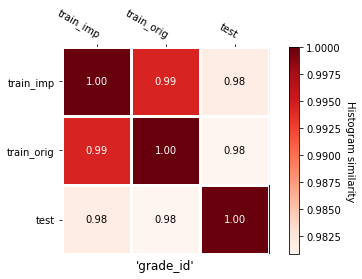

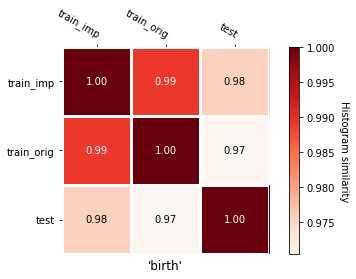

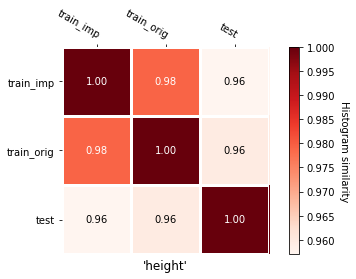

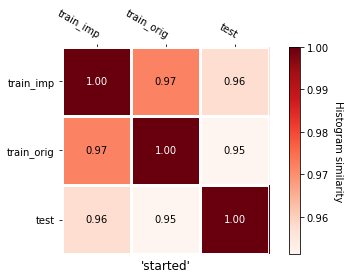

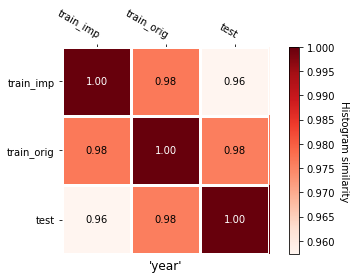

In [9]:
for feature in ranges:
    fig, ax = plt.subplots()
    
    im, cbar = heatmap(comparison_array[feature], list(df.keys()), list(df.keys()), ax=ax,
                       cmap="Reds", cbarlabel="Histogram similarity")
    texts = annotate_heatmap(im)
    plt.title("'{}'".format(feature), y=-0.1)
    fig.tight_layout()
    plt.savefig('fig/{}_sim.eps'.format(feature))

In [62]:
# Drop 'user_id' (useless)
df_cleaned.drop(columns='user_id')
# Swap columns 'is_onsight' and 'year'
columnsTitles=["country", "is_female", "height", "started", "birth", "grade_id", "year", "is_bouldering", "year", "is_onsight"]
# Construct the dataset
dataset = df_cleaned.reindex(columns=columnsTitles)
dataset.to_csv('ds.csv')